In [12]:
import torch 
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from scvi.distributions import NegativeBinomial

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/scportrait_ot/src")

from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path

### Initialize dataset

In [13]:
dataset = EmbeddingDecoderDataset(adata_path="/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/data/citeseq/CITEseq_rna_processed_full_genome.h5ad", 
                                     count_label="X_normalized_log", 
                                     embedding_label="X_harmony_RNA",
                                     batch_label="donor_id")

Initialize dataloaders

In [14]:
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size=256,
                                        shuffle=True,
                                        num_workers=4)

### Initialize model 

In [15]:
decoder_model = DecoderFromHarmony(input_dim=dataset.input_dim, 
                                   output_dim=dataset.output_dim,
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3,
                                   likelihood="gaussian"
                                  )

In [16]:
decoder_model

DecoderFromHarmony(
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=50, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=17288, bias=True)
    )
  )
)

In [17]:
decoder_model.load_state_dict(torch.load("/home/icb/alessandro.palma/environment/scportrait_ot/project_folder/experiements/decoder_cite_log_whole_genome/pretty-music-1/checkpoints/last.ckpt")["state_dict"])

<All keys matched successfully>

## Check reconstruction  

In [21]:
Xs = []
X_hat = []

with torch.no_grad():
    for batch in dataloader:
        Xs.append(batch["X"])
        mu_hat = decoder_model.decoder(batch["X_emb"])
        X_hat.append(mu_hat)

In [22]:
X_hat = torch.cat(X_hat, dim=0).cpu().detach().numpy()
Xs = torch.cat(Xs, dim=0).cpu().detach().numpy()
idx = torch.randint(0, X_hat.shape[0], (30000,))
X_hat = X_hat[idx]
Xs = Xs[idx]

In [23]:
obs = pd.DataFrame({"data_type": ["real" for _ in range(30000)]+["reconstructed" for _ in range(30000)]})

In [24]:
adata_generated = sc.AnnData(X=np.concatenate([Xs, X_hat]), 
                            obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/icb/alessandro.palma/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


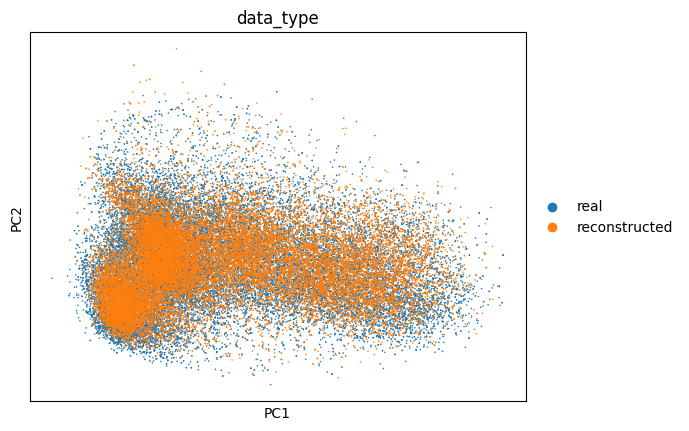

In [26]:
sc.pl.pca(adata_generated, color="data_type", s=5)

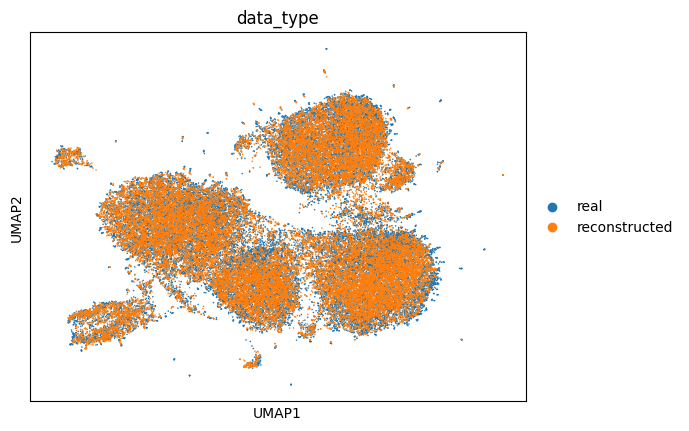

In [27]:
sc.pl.umap(adata_generated, color="data_type", s=5)